prepared by Eric Kimwatan

### Task 1: Descriptive analytics

In [620]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [621]:
#loading libraries and loading data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import pickle

data = pd.read_csv('data_anonymized.csv')

In [622]:
#Looking at the first few row of data
print(data.shape)
data.head()

(55316, 19)


,Unnamed: 0,treatment_id,claim_id,claim_amount,claim_status,payment_type,date_treatment,date_submitted,date_modified,provider_name,provider_type,patient_ref_id,patient_gender,patient_age,diagnosis_code,item_name,item_quantity,item_amount,item_status
0,0,treatment 0,claim 0,500.0,Approved,Voucher,2018-02-16 12:44:07,2018-02-16 12:53:25,2018-02-16 12:53:25,provider 0,NaN,patient 0,MALE,26.0,diagnosis 0,item 0,1.0,200.0,ACTIVE
1,1,treatment 1,claim 1,5.0,Approved,Insurance,2018-04-21 06:06:28,2018-04-21 06:11:26,2018-04-21 06:11:27,provider 1,Test Clinic,patient 1,MALE,37.0,diagnosis 1,item 1,1.0,10.0,ACTIVE
2,2,treatment 2,claim 2,0.0,Approved,Insurance,2018-04-17 12:23:06,2018-04-17 12:39:23,2018-04-17 12:39:24,provider 2,NaN,patient 2,MALE,30.0,diagnosis 2,item 2,10.0,2.0,ACTIVE
3,3,treatment 3,claim 3,3000.0,Draft,Insurance,2018-05-22 09:26:34,NaN,2018-05-22 09:43:44,provider 3,NaN,patient 3,MALE,42.0,diagnosis 1,item 3,1.0,150000.0,ACTIVE
4,4,treatment 4,claim 4,200.0,Deleted,Insurance,2018-04-16 06:05:10,NaN,2018-04-16 07:14:47,provider 4,NaN,patient 4,FEMALE,30.0,diagnosis 3,item 4,1.0,200.0,ACTIVE


In [623]:
#information about the columns data type and non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55316 entries, 0 to 55315
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      55316 non-null  int64  
 1   treatment_id    55316 non-null  object 
 2   claim_id        55316 non-null  object 
 3   claim_amount    55285 non-null  float64
 4   claim_status    55316 non-null  object 
 5   payment_type    55316 non-null  object 
 6   date_treatment  55316 non-null  object 
 7   date_submitted  46541 non-null  object 
 8   date_modified   54899 non-null  object 
 9   provider_name   55316 non-null  object 
 10  provider_type   2517 non-null   object 
 11  patient_ref_id  55316 non-null  object 
 12  patient_gender  55304 non-null  object 
 13  patient_age     55310 non-null  float64
 14  diagnosis_code  55316 non-null  object 
 15  item_name       55316 non-null  object 
 16  item_quantity   52230 non-null  float64
 17  item_amount     52230 non-null 

A number of variables appear to be having missing values. 
Provider_type and date_submitted seem to have the lowest number of nol-nulls.
I will investigate this further

In [624]:
#Checking % of missing values per column
data.isnull().sum()/len(data)*100

Unnamed: 0         0.000000
treatment_id       0.000000
claim_id           0.000000
claim_amount       0.056042
claim_status       0.000000
payment_type       0.000000
date_treatment     0.000000
date_submitted    15.863403
date_modified      0.753851
provider_name      0.000000
provider_type     95.449779
patient_ref_id     0.000000
patient_gender     0.021694
patient_age        0.010847
diagnosis_code     0.000000
item_name          0.000000
item_quantity      5.578856
item_amount        5.578856
item_status        5.578856
dtype: float64

I will drop 'provider_type' and 'date_submitted' since they have alot of missing values

In [625]:
#dropping provider_type, date_submitted and Unnamed variables
data = data.drop(['Unnamed: 0','provider_type', 'date_submitted'], axis=1)


#### Handling missing values

Since the dataset is imbalanced, I risk loosing data from the under-represented class. I will first check to see what impact dropping missing values has on the two major classes ie 'Approved' and 'Rejected'

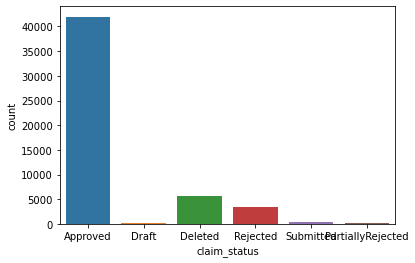

In [626]:
#Looking at the distribution of the claim status
sns.countplot(df['claim_status'])

In [627]:
#dropping rows with missing values
dropped_df = data.dropna()
print(dropped_df.shape)


(51944, 16)


In [628]:
dropped_df['claim_status'].value_counts()

Approved             41961
Deleted               5669
Rejected              3483
Submitted              315
Draft                  269
PartiallyRejected      247
Name: claim_status, dtype: int64

In [629]:
data['claim_status'].value_counts()

Approved             41978
Deleted               8592
Rejected              3485
Draft                  699
Submitted              315
PartiallyRejected      247
Name: claim_status, dtype: int64

The 'Rejected' records reduce by only 2 while the 'Approved' records reduce by 17. The impact on my classes of interest is very low so I will choose to drop the missing records.

In [630]:
#Creating a copy of the new dataset with no missing values
df = dropped_df.copy()


In [631]:
df.isnull().any()

treatment_id      False
claim_id          False
claim_amount      False
claim_status      False
payment_type      False
date_treatment    False
date_modified     False
provider_name     False
patient_ref_id    False
patient_gender    False
patient_age       False
diagnosis_code    False
item_name         False
item_quantity     False
item_amount       False
item_status       False
dtype: bool

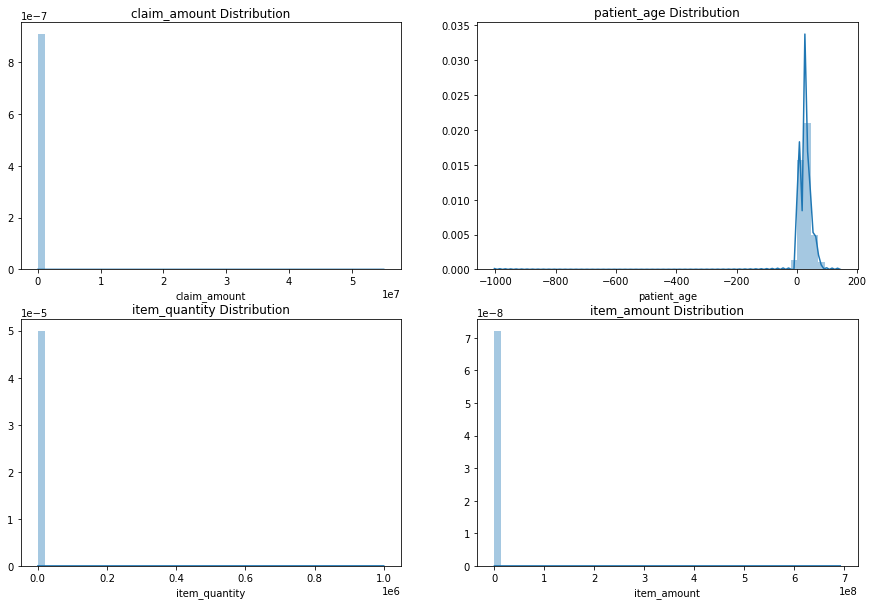

In [632]:
#Looking at the distribution of the numerical columns

num_cols = df.select_dtypes(include=np.number).columns.tolist()


fig, axes = plt.subplots(2, 2, figsize=(15,10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    plt.title(f'{col} Distribution')
    sns.distplot(df[col])
plt.show()


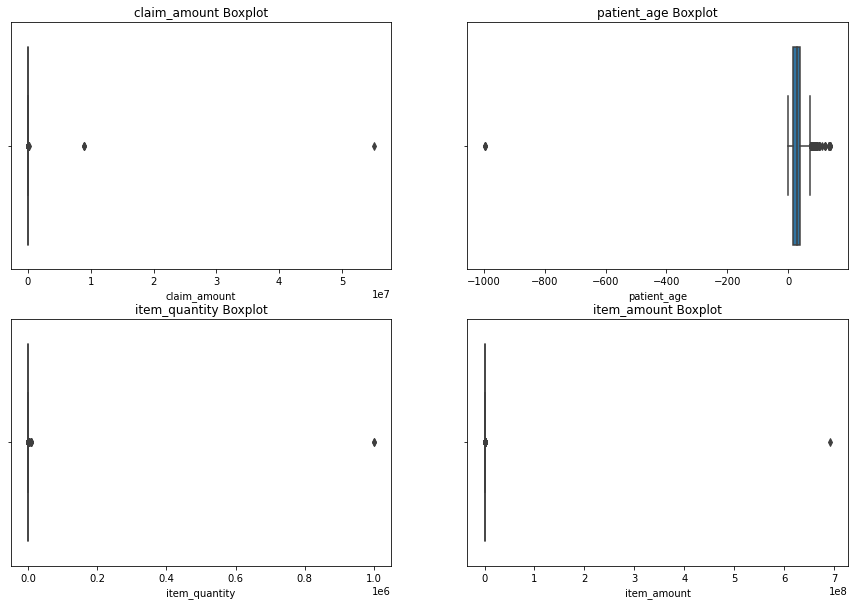

In [633]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))

for i, col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    plt.title(f'{col} Boxplot')
    sns.boxplot(df[col])
plt.show()

The histogram and boxplot suggest that the numerical attributes have extreme outliers forcing the observed shapes. This is however expected given the nature of the problem i.e anomaly detection

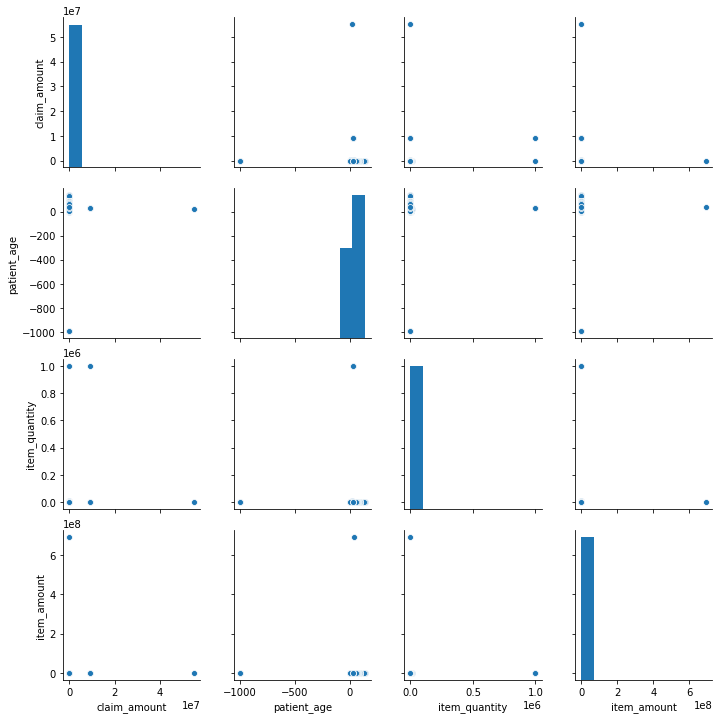

In [634]:
#Visualizing relationship between the numeric data
sns.pairplot(df)

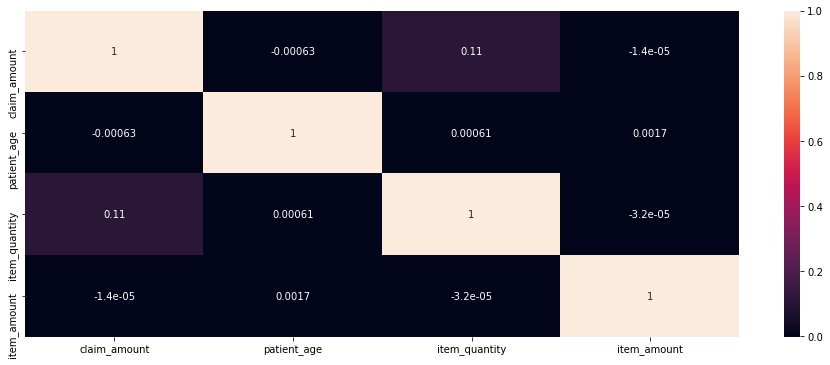

In [635]:
#Looking at correlations between the numerical variables
plt.figure(figsize=(16,6))
sns.heatmap(df.corr(), annot=True)

The claim amount and item_quantity have a weak positive relationship between them as expected.
The other variables have very small correlation values indicating no relationship

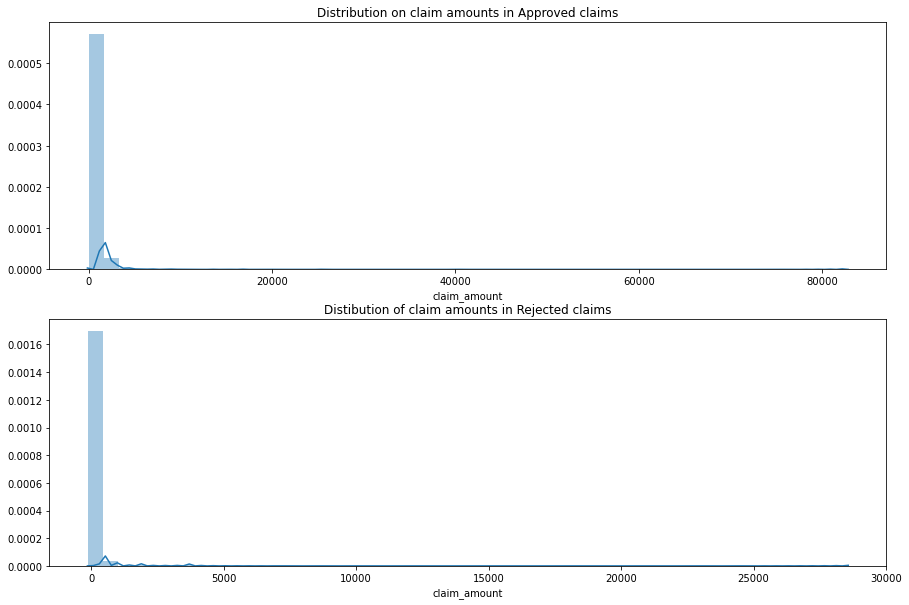

In [636]:

#Looking at the distribution of claim amounts in Approved and Rejected claims
approved = df[df['claim_status']=='Approved']
rejected = df[df['claim_status']=='Rejected']

fig, axes = plt.subplots(2, 1, figsize=(15,10))
axes[0].set_title('Distribution on claim amounts in Approved claims')
axes[1].set_title('Distibution of claim amounts in Rejected claims')
sns.distplot(approved['claim_amount'], ax=axes[0])
sns.distplot(rejected['claim_amount'], ax=axes[1])



There appears to be a difference between the distributions of claim amounts involving Approved and Rejected claims. Claim amounts could be a potential feature in determining anomaly

In [637]:
#Getting a list of categorical columns and removing irrelevant ones
cat_cols = df.select_dtypes(include='object').columns.tolist()
to_remove = ['patient_ref_id', 'claim_id', 'date_treatment', 'date_modified']
cat_cols_new = [c for c in cat_cols if c not in to_remove]

In [638]:
cat_cols_new

['treatment_id',
 'claim_status',
 'payment_type',
 'provider_name',
 'patient_gender',
 'diagnosis_code',
 'item_name',
 'item_status']

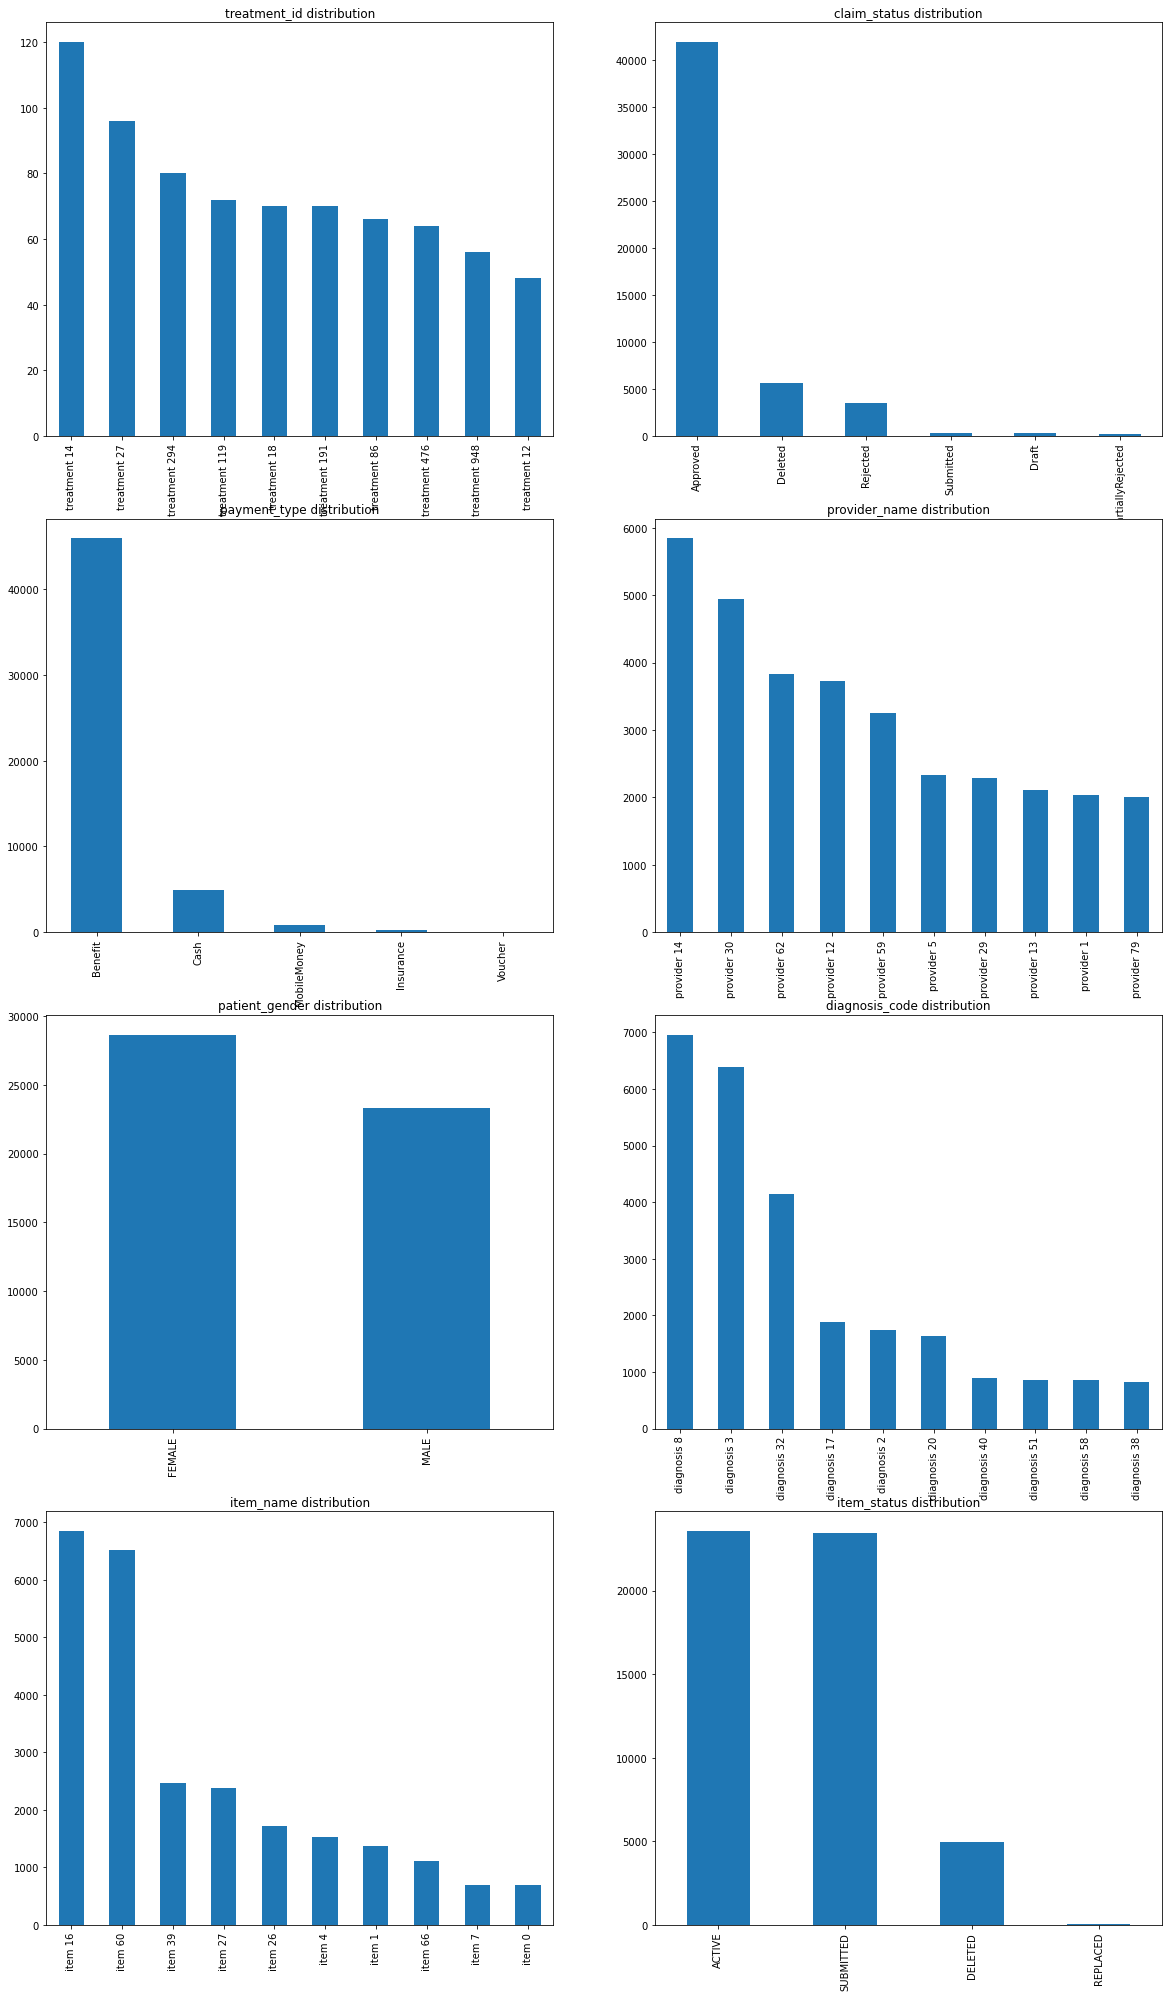

In [639]:
#Looking at the categorical variables and their distributions/occurence in the dataset
fig, axes = plt.subplots(4, 2, figsize=(20,35))
for i, col in enumerate(cat_cols_new):
    plt.subplot(4, 2, i+1)
    
    plt.title(f'{col} distribution')
      
    df[col].value_counts().nlargest(10).plot.bar()


The most common payment type is 'benefit' then 'cash' payments.
There are more female then male patients in the dataset and the 2 most common items are item 16 and 60.

#### Looking at the categorical variables in ralation to the Approved and Rejected claims

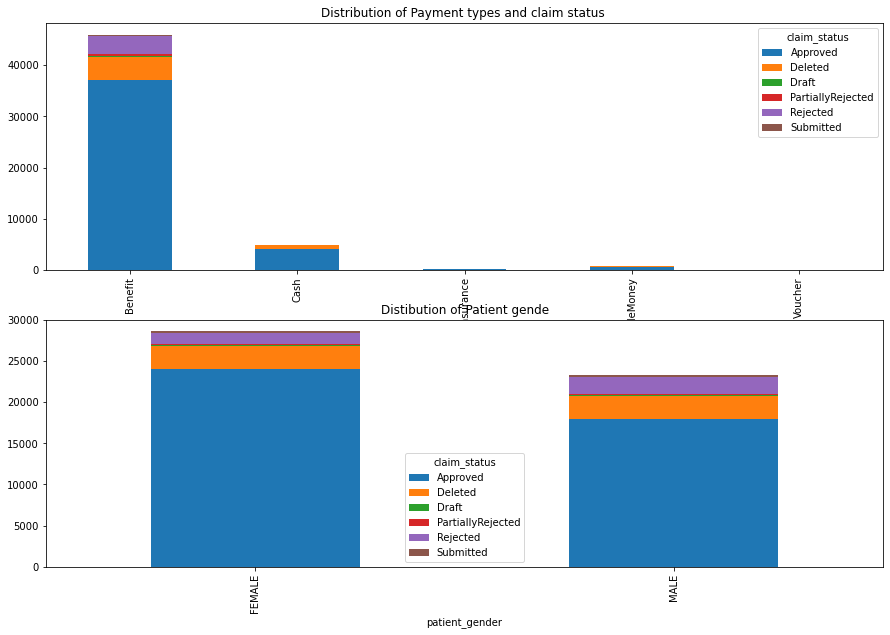

In [640]:

fig, axes = plt.subplots(2, 1, figsize=(15,10))
axes[0].set_title('Distribution of Payment types and claim status ')
axes[1].set_title('Distibution of Patient gende')


pd.crosstab(df['payment_type'], df['claim_status']).plot.bar(stacked=True, ax=axes[0])
pd.crosstab(df['patient_gender'], df['claim_status']).plot.bar(stacked=True, ax=axes[1])

Because of the class imbalance, it is difficult to spot differences in the categorical features in regard to claim status.

### Task 2.Anomaly detection Engine

In [641]:
#Selecting only approved claims
data_new = pd.read_csv('data_anonymized.csv')

df_approved = data_new[data_new['claim_status']=='Approved']
df_rejected = data_new[data_new['claim_status']=='Rejected']
print(df_approved.shape)
df_approved.head()

(41978, 19)


,Unnamed: 0,treatment_id,claim_id,claim_amount,claim_status,payment_type,date_treatment,date_submitted,date_modified,provider_name,provider_type,patient_ref_id,patient_gender,patient_age,diagnosis_code,item_name,item_quantity,item_amount,item_status
0,0,treatment 0,claim 0,500.0,Approved,Voucher,2018-02-16 12:44:07,2018-02-16 12:53:25,2018-02-16 12:53:25,provider 0,NaN,patient 0,MALE,26.0,diagnosis 0,item 0,1.0,200.0,ACTIVE
1,1,treatment 1,claim 1,5.0,Approved,Insurance,2018-04-21 06:06:28,2018-04-21 06:11:26,2018-04-21 06:11:27,provider 1,Test Clinic,patient 1,MALE,37.0,diagnosis 1,item 1,1.0,10.0,ACTIVE
2,2,treatment 2,claim 2,0.0,Approved,Insurance,2018-04-17 12:23:06,2018-04-17 12:39:23,2018-04-17 12:39:24,provider 2,NaN,patient 2,MALE,30.0,diagnosis 2,item 2,10.0,2.0,ACTIVE
5,5,treatment 5,claim 5,495.0,Approved,Insurance,2018-12-22 17:26:36,2018-12-22 17:54:39,2018-12-22 17:54:40,provider 5,NaN,patient 5,FEMALE,37.0,diagnosis 4,item 5,1.0,0.0,DELETED
7,7,treatment 2,claim 2,0.0,Approved,Insurance,2018-04-17 12:23:06,2018-04-17 12:39:23,2018-04-17 12:39:24,provider 2,NaN,patient 2,MALE,30.0,diagnosis 2,item 7,1.0,2.0,ACTIVE


In [642]:
#Getting anomaly proportion using just rejected cases to use as a hyperparameter in modelling
outlier_proportion = len(df_rejected)/len(df_approved)
print(f'Outlier proportion is {outlier_proportion}')

Outlier proportion is 0.08301967697365287


In [643]:
#Selecting features
feats = ['claim_amount', 'item_quantity']
X = df_approved[feats]


In [644]:
#Fitting an IsolationForest Model on the data
    
model = IsolationForest(n_estimators=100, contamination=0.08)
preds = model.fit_predict(X)
labels = df_approved['claim_status']
train_metrics = pd.DataFrame(labels)
train_metrics['preds'] = preds
train_metrics['scores'] = model.decision_function(X)

behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.


In [645]:
#mapping claim_status and preds to 1 and 0
d1 = {'Rejected':0, 'Approved':1}
train_metrics = train_metrics.replace({'claim_status':d1})

#mapping preds to 1 and 0
d2 = {-1:0, 1:1}
train_metrics = train_metrics.replace({'preds':d2})

In [646]:
train_metrics.head()

,claim_status,preds,scores
0,1,1,0.146793
1,1,1,0.139265
2,1,1,-0.011007
5,1,1,0.146752
7,1,1,0.169837


In [649]:
#Model performance evaluation function
def evaluate(df):
    """Evaluate performance of a model and returns evaluation metrics."""
    print('Confusion Matrix:')
    print(confusion_matrix(df['claim_status'], df['preds'], ))
    print('Classification Report:')
    print(classification_report(df['claim_status'],df['preds']))
    print('Accuracy score:')
    print(accuracy_score( df['claim_status'],df['preds']))


In [650]:
#Testing on accepted claims
evaluate(train_metrics)

Confusion Matrix:
[[    0     0]
 [ 3110 38868]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.93      0.96     41978

    accuracy                           0.93     41978
   macro avg       0.50      0.46      0.48     41978
weighted avg       1.00      0.93      0.96     41978

Accuracy score:
0.9259135737767402


In [651]:
#Testing on rejected claims
df_rejected = df_rejected.dropna()
rejected_labels = df_rejected['claim_status']
X_rejected = df_rejected[feats]


rejected_preds = model.predict(X_rejected)
rejected_metrics = pd.DataFrame(rejected_labels)
rejected_metrics['preds'] = rejected_preds

d1 = {'Rejected':0, 'Approved':1}
rejected_metrics = rejected_metrics.replace({'claim_status':d1})

d2 = {-1:0, 1:1}
rejected_metrics = rejected_metrics.replace({'preds':d2})


In [652]:
rejected_metrics.head()

,claim_status,preds
99,0,1
113,0,1
202,0,1
244,0,1
273,0,1


In [653]:
evaluate(rejected_metrics)

Confusion Matrix:
[[ 18 671]
 [  0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.05       689
           1       0.00      0.00      0.00         0

    accuracy                           0.03       689
   macro avg       0.50      0.01      0.03       689
weighted avg       1.00      0.03      0.05       689

Accuracy score:
0.026124818577648767


In [654]:
#Using Model on the test data

test = pd.read_csv('test_data.csv')
test_feats = test[feats]
y_test = test['claim_status']
test_metrics = pd.DataFrame(y_test)
#mapping Approved and rejected to 1 and 0
d1 = {'Anomaly':0, 'Approved':1}
test_metrics = test_metrics.replace({'claim_status':d1})
#Using the model for prediction
preds_test = model.predict(test_feats)
test_metrics['preds'] = preds_test
test_metrics['scores'] = model.decision_function(test_feats)
d2 = {-1:0, 1:1}
test_metrics = test_metrics.replace({'preds':d2})

In [655]:
#Evaluating model performance on test data
evaluate(test_metrics)

Confusion Matrix:
[[ 65 139]
 [  0   0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.32      0.48       204
           1       0.00      0.00      0.00         0

    accuracy                           0.32       204
   macro avg       0.50      0.16      0.24       204
weighted avg       1.00      0.32      0.48       204

Accuracy score:
0.31862745098039214


In [656]:
#saving the trained model to be used in the claims scoring function

pickle.dump(model, open('model.pkl', 'wb'))

In [657]:
#Function that returns approvability score.

def check(claim):
    """function that takes a claim in dictionary format
    and returns a score of approvability.
    """
    model = pickle.load(open('model.pkl', 'rb'))
    feats = ['claim_amount', 'item_quantity']
    list = []
    for key, value in claim.items():
        if key in feats:
            list.append(value)
    numbers = [np.array(list)]
    prediction = model.predict(numbers)
    score = model.decision_function(numbers)
    if prediction == -1:
        decision = 'Reject'
    else:
        decision = 'Approve'
    
    print(f'The claim has an approvability score of {score} and recommendation is to {decision}')
        

In [660]:
#Testing function with simulated claims data
x = {'treatment_id':2001, 'claim_id':'claim 3674','payment_type': 'mobile_money', 
     'claim_amount':200,'item_quantity':10}
check(x)

The claim has an approvability score of [-0.01785999] and recommendation is to Approve


### Task 3.Work plan

###### ***GOAL***
***To deploy an anomaly detection model in production***


| Phase                                                 | Key Tasks                                                                                                                                                           | Duration |   |   |
|-----------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------|---|---|
| 1. Prepare code documentation and unit tests              | 1. Write unit tests and test cases<br>2. Documenting data collection methods                                                                                        | 4 Weeks  |   |   |
| 2. Creating a web service to serve the model              | 1. Setting up cloud environment<br>2. Writing REST API's<br>3. Test functionalities                                                                                 | 6 Weeks  |   |   |
| 3. Set up live monitoring of model performance            | 1.Setting up downstream metrics to use for evaluation<br>eg actual reported rejections/fraud<br>2. Set up alerts for when model performance drops below a threshold | 4 weeks  |   |   |
| 4. Set up continous integration and deployment pipelines  | 1. Set up CI/CD platforms eg Jenkins                                                                                                                                | 3 Weeks  |   |   |
| 5.Model retraining and tuning                                        | 1. Setting up automatic fresh data collection<br>2. Setting up automated retraining and deployment                                                                  | 5 Weeks  |   |   |

### Bonus Task Explainable Models

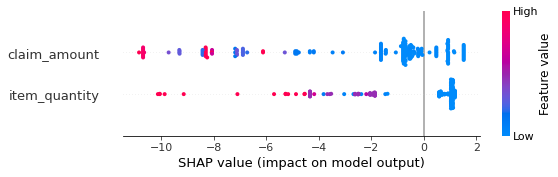

In [567]:
#Using shap to view the summary of model explaination
import shap

X_explain = test_feats
shap_values = shap.TreeExplainer(model).shap_values(X_explain)
shap.summary_plot(shap_values, X_explain)

From the plot we can see that high values of claim_amount and item_quantity tend to correlate with lower probability of getting approved. This makes sense because, claims with extremely high amount claims are more likely to be flagged for investigation or rejection
